In [1]:
%matplotlib inline

# Goals

1. Introduce the problem of ecological inference

2. Describe the hierarchical Bayesian approach to 2x2 ecological inference as introduced in [2, 3]

3. Use python and PyMC3 to implement the model and obtain posterior samples using MCMC techniques (with simulated and real data)

4. Provide some familiarity with the use of ecological inference in the context of voting rights [6]



# Contents

[The problem](#The-problem)

[A hierarchical Bayesian approach](#A-hierarchical-Bayesian-approach)

[Extending the model to include covariates](#Extending-the-model-to-include-covariates)

[Examples with code](#Examples-with-code):

[1. A toy example](#1.-A-toy-example) 

[2. An example with data simulated from the generative model](#2.-An-example-with-data-simulated from-the-generative-model)

[3. An example with real voting data](#3.-An-example-with-real-voting-data)

[4. An example with real voting data and covariates](#4.-An-example-with-real-voting-data-and-covariates)

[References](#References)



# The problem
In an *ecological inference* problem, broadly speaking, the task is to infer individual-level behavior from the behavior of groups.  Does that sounds like a hard problem?  It is!

It also has important applications to voting rights.

Let's make the problem more concrete.  Here we look at the "two by two" case.  We have group data about two different binary characteristics of several populations - say, what percentage is falls in some "Group 1" and what precentage is in some different and overlapping classification "Group A".  We would then like to ask questions like "what percentage of Group 1 members are also in Group A?". 

Put another way, we know the marginal distributions in the following 2 x 2 table, and we want to infer the values of each of the cells marked with question marks.

| Population i |    Group A   |  Not Group A  |            |
|----------------------------------------------------------|
| **Group 1**  |     *?*      |      *?*     |   $X_i $    |
| **Group 2**  |     *?*      |       *?*    |  $1-X_i $   |
|              |     $ T_i  $ |     $1-T_i $ |             |

We imagine having such a table for a number $p$ of different populations: $i = 1,..., p$.  We denote the size of population $i$ by $N_i$.

In the area of voting rights, we may be interested in voting rates of different groups.  We may also want to know the rates at which voters in one group vote for a particular candidate or party, but this data is unavailable because ballots are secret.  

From what I understand, this latter kind of information is actually essential in the area of voting rights, since a racial group being 'politically cohesive' was declared to be one component of a justiciable vote dilution claim in Thornburgh v. Gigles (478 U.S. 30-108) [6][7]

We illustrate with an example from [King 1997] applying ecological inference to $p=268$ precincts in 1968.  In the $i$th distict we know the percentage the voting age population that is black ($X_i$) and white ($1-X_i$)†, the proportion of voting age members of the district who are registered to vote ($T_i$), and size of the total voting age population ($N_i$).  From this we wish to infer the proportion of black voting age members of the population who are registered to vote and the proportion of white voting age members of the population who are registered to vote.

| District  i  |  Registered  | Not Registered |           |
|--------------|--------------|----------------|-----------|
| **Black**    |     *?*      |      *?*       |   $X_i $  |
| **White**    |     *?*      |       *?*      |  $1-X_i $ |
|              |     $ T_i  $ |     $1-T_i $   |           |

†In the data used in King the population of these 1968 counties is grouped into black and white only.



# A hierarchical Bayesian approach

Now we describe the hierarchical Bayesian approach to 2x2 ecological inference as introduced in [2, 3]

    
### Observed quantities  

$\begin{align}
X_i &= \text{ fraction of population i who are in Group 1} \\
&= \text{ fraction of voting age people in precinct i who are black}
\end{align}$
   
$\begin{align}   
T_i &= \text{ fraction of population i who are in Group A}\\
&= \text{ fraction of voting age people who are registered to vote in precinct i}
\end{align}$

$\begin{align}
N_i &= \text{ size of population i} \\
&= \text{ number of voting age people in precinct i}
\end{align}$

$\begin{align}
T'_i &= \text{ number of people in population i who are in Group A}\\
 &= \text{ number of people in precinct i who are registered to vote}
\end{align}$
           
    
### Unobserved parameters of interest
$\begin{align} b1_i &= \text{fraction of Group 1 members in population i that are in Group A} \\
 &= \text{fraction of black voting age population in precinct i that is registered to vote}
\end{align}$

$\begin{align}
b2_i &= \text{ fraction of Group 2 members in population i that are in Group A} \\
&= \text{ fraction of white voting age population in precinct i that is registered to vote}
\end{align}$  


### Other unobserved parameters
$\begin{align}
\theta_i &= X_i * b1_i + (1-X_i) * b2_i \\
  &= \text{ expected fraction of population i that is in Group A} \\        
  &= \text{ expected fraction of the population of precinct i that is registered to vote}
\end{align}$
        
$c_1, d_1$ = hyperparameters for beta distribution that governs each of the $b1_i$

$c_2, d_2$ = hyperparameters for beta distribution that governs each of the $b2_i$

$\lambda$ = fixed hyperparameter for exponential distributions of $c_1, d_1, c_2, d_2$.  In our examples we use $\lambda = 0.5$ to match [King 1999]
    
       
### The model
   
   $c_{1} \sim Exponential(\lambda)$
   
   $d_{1} \sim Exponential(\lambda)$
   
   $c_{2} \sim Exponential(\lambda)$
   
   $d_{2} \sim Exponential (\lambda)$
   
   $b1_i \, \mid \, c_1, d_1 \sim Beta(c_1, d_1)$
   
   $b2_i \, \mid \, c_2, d_2 \sim Beta(c_2, d_2)$
   
   $T'_i \, \mid \, b1_i, b2_i, X_i \sim Binomial(N_i, \theta_i)$



<img src="EI_Graphical_Model_5.png">

# Extending the model to include covariates

We may want our generative model for $b1_i$ and $b2_i$ to take into account additional variables that characterize the the $i$ districts.  For instance, we may want the $b1_i$ and $b2_i$ to be drawn from a distribution whose parameters include some spatial information if we suspect, for example, that precincts that are geographically close might show similar patterns. 

To that end, suppose we have some covariate $Z_i$ measured for each precinct (here we assume $Z_i$ is a scalar, but the generalization to the case where $Z_i$ is a vector is straightforward).   The model can then be extended as follows [King, 1999].

To our list of observed quantities, add $Z_i$.

In our list of unobserved parameters, replace $c_1$ and $c_2$ with $\alpha, \beta, \gamma,$ and $\delta$.  

Give $\alpha$, $\beta$, $\gamma$ and $\delta$ a flat (improper) prior, and use $d_1 \exp(\alpha + \beta  Z_i), \, d_1$ as parameters for the beta distribution that governs $b1_i$, and $d_2 \exp(\gamma + \delta Z_i), \, d_2$ for the beta distribution that governs $b2_i$.  Note that with this choice of parameters for the beta distributions, the log odds of the expectation $b1_i$ and of $b2_i$ each depend linearly on $Z_i$ - that is, 
$$\log \dfrac{\mathbb{E}(b1_i)}{1- \mathbb{E}(b1_i)} = \alpha + \beta Z_i.$$

### The model with covariates

   $p(\alpha), p(\beta), p(\gamma), p(\delta) \propto 1$ 
   
   $d_{1} \sim Exponential(\lambda)$
   
   $d_{2} \sim Exponential(\lambda)$
   
   $b1_i \, \mid \, d_1, Z_i, \alpha, \beta \sim Beta(d_1 \exp(\alpha + \beta  Z_i), \, d_1)$
   
   $b2_i \, \mid \, d_2, Z_i, \gamma, \delta \sim Beta(d_2 \exp(\gamma + \delta Z_i), \, d_2)$   
   
   $T'_i \, \mid \, b1_i, b2_i, X_i  \sim Binomial(N_i, \theta_i)$

<img scr="EI_graphical_model_cov.png">  

<img src="EI_graphical_model_cov.png"> 

# Examples with code

There is a nice R package for all this and more [1].  Let's see how we can make it happen in Python!

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas

In [2]:
def ei_two_by_two(X, T, N, lmbda):
    Tprime_obs = T * N
    p = len(X) #number of populations
    with pm.Model() as model:   
        c_1 = pm.Exponential('c_1', lmbda)
        d_1 = pm.Exponential('d_1', lmbda)
        c_2 = pm.Exponential('c_2', lmbda)
        d_2 = pm.Exponential('d_2', lmbda)
        
        b_1 = pm.Beta('b_1', alpha=c_1, beta=d_1, shape=p)
        b_2 = pm.Beta('b_2', alpha=c_2, beta=d_2, shape=p)
    
        theta = X * b_1 + (1 - X) * b_2
        Tprime = pm.Binomial('Tprime', n=N , p=theta, observed=Tprime_obs)       
    return model

### 1. A toy example
Let's imagine we have as four voting precincts, each with 100 people in them.  The percentage of Group 1 present in each precinct is 10%, 20%, 30% or 40% respectively ($X$).  The percentage of each precinct voting for some political candidate A is 11%, 18%, 34% or 40% respectively ($T$).

It looks like X and T are tracking pretty closely.  Does this mean that members of Group 1 overwhelmingly support candidate A, while members of Group 2 do not?  (What other explanations can you imagine?)

In [3]:
X = np.array([.1, .2, .3, .4])
T = np.array([.11, .18, .34, .4])
N = np.array([100, 100, 100, 100])

Now we set up our model and obtain MCMC samples from the posterior, using PyMC3:

In [6]:
lmbda = 0.5 #chosen to match [King, 1999]

toy_model = ei_two_by_two(X, T, N, lmbda)

with toy_model:
    toy_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:12<00:00, 25.20it/s]/Users/colin/projects/pymc3/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.679785112819, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/colin/projects/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 46 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



We can use PyMC3 to plot the traces:

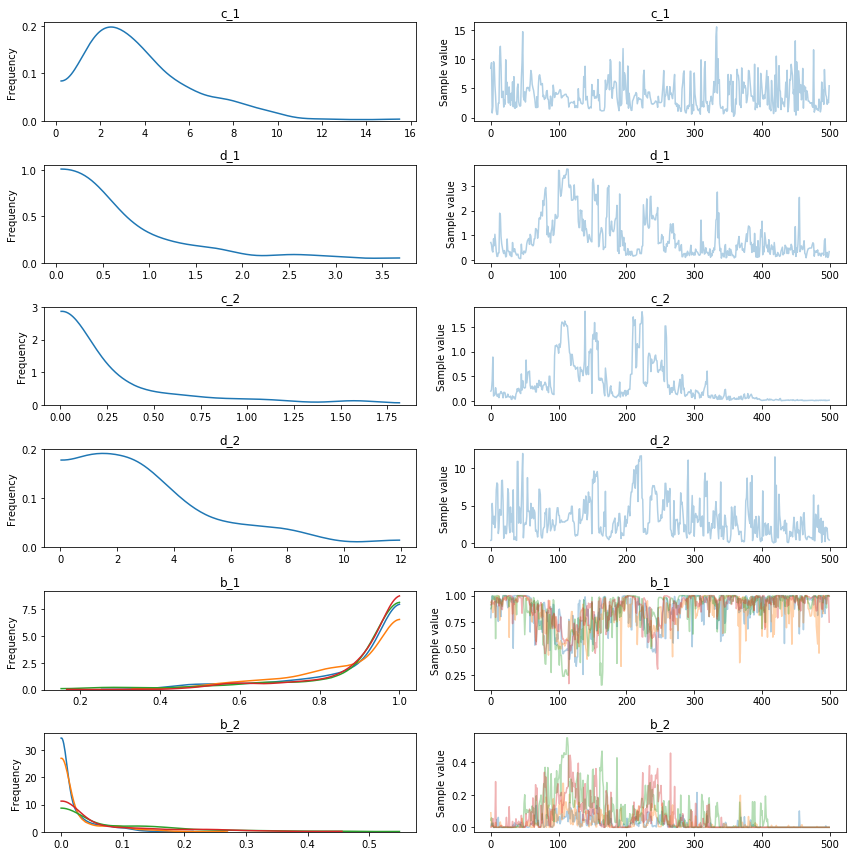

In [8]:
pm.traceplot(toy_trace);

Having obtained our samples, we access some statistics of interest.  (Note how broad the 95% HPD interval is for the $b1_i$ !) 

In [9]:
print("b_1 mean across districts: "+ str(toy_trace.get_values('b_1').mean()))

pm.stats.summary(toy_trace, varnames=['b_1', 'b_2'])

b_1 mean across districts: 0.8673846099

b_1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.866            0.161            0.013            [0.495, 1.000]
  0.850            0.148            0.012            [0.545, 1.000]
  0.868            0.187            0.016            [0.436, 1.000]
  0.886            0.139            0.012            [0.572, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.458          0.792          0.938          0.992          1.000
  0.507          0.767          0.887          0.980          1.000
  0.297          0.810          0.956          0.996          1.000
  0.534          0.848          0.943          0.985          1.000


b_2:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------

### 2. An example with data simulated from the generative model


Simulate some data from the model:

In [4]:
X = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])
N = np.array([100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0])
p = len(X) # Number of districts

c_1= 12.0
d_1 = 3.0
c_2= 6.0
d_2 = 8.0

b_1_sim = []
b_2_sim = []
theta_sim = []
Tprime_sim = []

for i in range(p):
    b_1_sim.append(np.random.beta(c_1, d_1))
    b_2_sim.append(np.random.beta(c_2, d_2))
    theta_sim.append( X[i] * b_1_sim[i] + (1 - X[i]) * b_2_sim[i])
    Tprime_sim.append(np.random.binomial(N[i], theta_sim[i]))

T = np.array(Tprime_sim / N)


Obtain MCMC samples from the posterior:

In [5]:
lmbda = 0.5 #chosen to match [King, 1999]

sim_model =  ei_two_by_two(X, T, N, lmbda)

with sim_model:
    sim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 48.202:   4%|▎         | 7248/200000 [00:01<00:46, 4125.60it/s]
Convergence archived at 7700
Interrupted at 7,700 [3%]: Average Loss = 62.253
 99%|█████████▉| 990/1000 [00:08<00:00, 164.63it/s]/Users/karin/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 7 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [00:08<00:00, 114.11it/s]


In [32]:
for i in range(p):
    print("posterior mean b1_" + str(i) + " = " + str(sim_trace.get_values('b_1')[:,i].mean()) ) 
    print("true model has b1_" + str(i) + " = " + str(b_1_sim[i]))
    print("")

posterior mean b1_0 = 0.778888312373
true model has b1_0 = 0.745376395329

posterior mean b1_1 = 0.742030747148
true model has b1_1 = 0.87254426952

posterior mean b1_2 = 0.777927878964
true model has b1_2 = 0.731777491371

posterior mean b1_3 = 0.777537093586
true model has b1_3 = 0.79646088171

posterior mean b1_4 = 0.788865216649
true model has b1_4 = 0.836575975529

posterior mean b1_5 = 0.877057540023
true model has b1_5 = 0.894897810105

posterior mean b1_6 = 0.808593072371
true model has b1_6 = 0.758291095837

posterior mean b1_7 = 0.782967233299
true model has b1_7 = 0.845652632361

posterior mean b1_8 = 0.795108674962
true model has b1_8 = 0.85988308415



### 3. An example with real voting data

Now we apply this method of ecological inference to data in [King 1997, 1990], as distributed in [1].  Our goal is to reproduce this example using PyMC3.  While we use the data and model of [King 1999],[6], the computational method of sampling differs; we sample with NUTS in PyMC3[5] while [King 1999] used a Metropolis method to obtain the MCMC samples.

The data represents $p$=268 precincts in 1968. We know for each district the percentage the voting age popoulation that is black ($X_i$) and white, the percentage of voting age members of the district who are registered to vote ($T_i$), and size of the total voting age population ($N_i$). 

This data set is useful because it also contains 'ground truth' measurements of the proportion of black voting age members of the population who are registered to vote and the proportion of white voting age members of the population who are registered to vote.  We can compare the results of the inference to these measurements.

In [63]:
#Load the data
data = pandas.read_csv('ei_example.csv')
X = np.array(data.x)
N = np.array(data.n)
T = np.array(data.t)
Tprime = np.array(T * N)
p = len(X)

We set up and sample from the model:

In [62]:
lmbda = 0.5 #chosen to match [King, 1999]

voter_model =  ei_two_by_two(X, T, N, lmbda)

with voter_model:
    voter_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 3,163.8:  15%|█▌        | 30280/200000 [00:18<01:40, 1685.60it/s]  
Convergence archived at 30300
Interrupted at 30,300 [15%]: Average Loss = 1.8151e+05
100%|█████████▉| 999/1000 [07:53<00:00,  1.99it/s]/Users/karin/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/Users/karin/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 59 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s]


Let us look at posterior samples of $\dfrac{c_1}{c_1 + d_1}$, the mean of the beta distribution which governs the $b1_i$. We compare them to samples of $\dfrac{c_2}{c_2 + d_2}$.

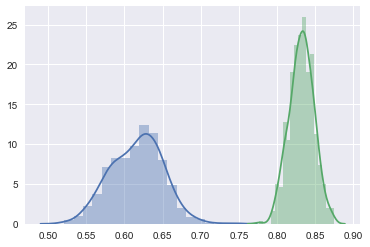

In [66]:
sns.distplot(voter_trace.get_values('c_1')/(voter_trace.get_values('c_1') + voter_trace.get_values('d_1')));
sns.distplot(voter_trace.get_values('c_2')/(voter_trace.get_values('c_2') + voter_trace.get_values('d_2')));

A look at these graphs certainly suggests a marked difference in the rates of voter registration between black (samples in blue) and white (samples in green) voters in these 268 sampled counties in 1968.

We can also look at the posterior means of the the $b1_i$ and $b2_i$ for each county, and compare our inferred values.

### 4. An example with real voting data and covariates

We modify the previous 1968 voting rate example by providing a covariate $Z$.  For the sake of an easy example with the same data set, and to parallel [King 1999], we use $Z = X$ as our covariate.  This allows us to consider the question of whether there is some effect of $Z_i = X_i$, the fraction of voters in a precinct who are black, on the rates of black and white voter registration.  Using different covariate(s) (for example, spatial variables) would also be interesting.

In [12]:
def ei_two_by_two_cov(Z, X, T, N, lmbda):
    with pm.Model() as covariate_model: 
        p = len(X)
        Tprime_obs = T * N
        
        alp = pm.Flat('alp')
        bet = pm.Flat('bet')
        gam = pm.Flat('gam')
        dlt = pm.Flat('dlt')
        
        d_1 = pm.Exponential('d_1', lmbda)
        d_2 = pm.Exponential('d_2', lmbda)

        c_1 = d_1*pm.math.exp(alp + bet*Z)
        c_2 = d_2*pm.math.exp(gam + dlt*Z)
    
        b_1 = pm.Beta('b_1', alpha = c_1, beta = d_1, shape=p)
        b_2 = pm.Beta('b_2', alpha = c_2, beta = d_2, shape=p)
    
        theta = X * b_1 + (1 - X) * b_2
        Tprime = pm.Binomial('Tprime', n=N , p=theta, observed=Tprime_obs)
    
    return covariate_model

In [73]:
Z = X  # As a simple example, use X as the covariate

cov_model = ei_two_by_two_cov(Z, X, T, N, lmbda) 

# Generate MCMC samples from the model
with cov_model:
    cov_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 3,118.6:  15%|█▍        | 29599/200000 [00:21<02:24, 1178.41it/s]  
Convergence archived at 29600
Interrupted at 29,600 [14%]: Average Loss = 1.8586e+05
100%|██████████| 1000/1000 [13:17<00:00,  1.55it/s]/Users/karin/anaconda/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 8 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



Perhaps we are interested in $\delta$, which governs the relationship between $Z_i$ and the beta distribution that governs $b2_i$.  Recall that under the model, 
$$\log \dfrac{\mathbb{E}(b2_i)}{1- \mathbb{E}(b2_i)} = \gamma + \delta Z_i.$$  

Note that the posterior distribution of $\delta$ is centered near 0, with a 95% HDP interval of [-1.437, 1.458].   So the log odds of the expected mean of $b2$ does not appear to depend linearly on $Z$.

-0.0130718575936

dlt:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.013           0.730            0.046            [-1.437, 1.458]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.637         -0.501         0.024          0.487          1.357



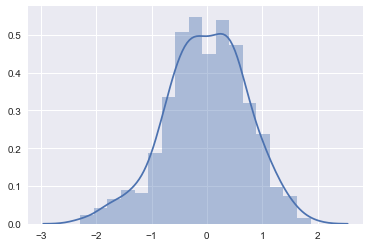

In [81]:
print(cov_trace.get_values('dlt').mean())

sns.distplot(cov_trace.get_values('dlt'))

pm.stats.summary(cov_trace, varnames=['dlt'])

# References

[1] King, Gary and Roberts, Molly.(2016).  ei: Ecological Inference. R package
  version 1.3-3.
  
[2] King, Gary, Ori Rosen, and Martin A. Tanner. "Binomial-beta hierarchical models for ecological inference." Sociological Methods & Research 28.1 (1999): 61-90.

[3] King, Gary (1997). A Solution to the Ecological Inference Problem. Princeton, NJ: Princeton University Press.

[4] Rosen, Ori, et al. "Bayesian and frequentist inference for ecological inference: The R× C case." Statistica Neerlandica 55.2 (2001): 134-156.

[5] Salvatier J, Wiecki TV, Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55

[6] "Thornburg v. Gingles". https://ballotpedia.org/Thornburg_v._Gingles

[7] Metric Geometry and Gerrymandering Group https://sites.tufts.edu/gerrymandr/